In [27]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [28]:
from pyTVDN import TVDNDetect, TVDNRankTuning
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline
plt.style.use('ggplot')

In [29]:
from scipy.signal import lfilter, firls, decimate

In [30]:
from pprint import pprint
import pickle
from easydict import EasyDict as edict
import warnings
from pyTVDN.TVDNutils import *
from pyTVDN.utils import in_notebook
if in_notebook():
    from tqdm import tqdm_notebook as tqdm
else:
    from tqdm import tqdm

class TVDNDetect1(TVDNDetect):
    def __init__(self, Ymat, ReconXmat, smoothType="Bspline", dataType=None, 
                 saveDir=None, showProgress=True, **paras):
        """
        Input:
            Ymat: The data matrix, d x n
            dataType: real data type, fMRI or MEG
            saveDir: Dir to save the results, if not specified, not save
            paras: Other parameters. There are default valuesi but you may specify these parameters manually.
               Inlcuding:
                    kappa: The parameter of penalty in MBIC
                    Lmin: The minimal length between 2 change points
                    r: The rank setted beforehand, in most cases, r=rAct. If we have non-complex singular values, r < rAct
                    MaxM: int, maximal number of change point 
                    lamb: The smooth parameter for B-spline
                    downRate: The downsample factor, determine how many Ai matrix to contribute to estimate the eigen values/vectors.
                    decimateRate: Mainly for MEG data. The rate to decimate from MEG data.
                    T: The time course
                    is_detrend: Whether detrend data or not
                    fct: The factor to adjust h when estimating A matrix
                    fName:  The file name when saving the results
                    plotfct: The factor to adjust the time course when plotting
                    freq: The parameter used drawing the eigen values plots
        """
        self.Ymat = Ymat
        self.paras = edict()
        if dataType is not None:
            self.dataType = dataType.lower()
        else:
            self.dataType = dataType

        if smoothType is not None:
            self.smoothType = smoothType.lower()
        else:
            self.smoothType = smoothType


        if self.dataType == "meg":
            self.paras.kappa = 2.65
            self.paras.Lmin = 60
            self.paras.r = 6
            self.paras.MaxM = 19
            self.paras.lamb = 1e-4
            self.paras.downRate = 20
            self.paras.decimateRate = 10
            self.paras.T = 2
            self.paras.is_detrend = False
            self.paras.fct = 0.5
            self.paras.fName = "MEG"
            self.paras.plotfct = 30
            self.paras.freq = 60
            self.paras.nbasis = 10
        elif self.dataType == "fmri":
            self.paras.kappa = 2.65
            self.paras.Lmin = 4
            self.paras.r = 6
            self.paras.MaxM = 10
            self.paras.lamb = 1e-4
            self.paras.downRate = 4
            self.paras.decimateRate = None
            self.paras.T = 2
            self.paras.is_detrend = False
            self.paras.fct = 0.5
            self.paras.fName = "fMRI"
            self.paras.plotfct = 180
            self.paras.freq = 0.5
            self.paras.nbasis = 10
        else:
            self.paras.kappa = 2.65
            self.paras.Lmin = 4
            self.paras.r = 6
            self.paras.MaxM = 19
            self.paras.lamb = 1e-6
            self.paras.downRate = 4
            self.paras.decimateRate = None
            self.paras.T = 2
            self.paras.is_detrend = False
            self.paras.fct = 1
            self.paras.fName = "simu"
            self.paras.plotfct = 1
            self.paras.freq = 180
            self.paras.nbasis = 10
        keys = list(self.paras.keys())
        for key in paras.keys():
            self.paras[key] = paras[key]
        if showProgress:
            print("The parameters for detection are:")
            pprint(self.paras)
        
        if saveDir is not None:
            self.saveDir = Path(saveDir)
            if not self.saveDir.exists():
                self.saveDir.mkdir()
        else:
            self.saveDir = saveDir
            
        self.ReconXmat = ReconXmat
        self.showProgress = showProgress
        self.nYmat = None
        self.Xmat = None
        self.dXmat = None
        self.time = None
        self.midRes = None
        self.nXmat = None
        self.ndXmat = None
        self.Amat = None
        self.finalRes = None
        self.RecYmatAll = None
        self.RecResCur = None
        self.numchgs = None
        self.ecpts = None
        self.canpts = None
    
    
    def GetRecResCur(self):
        numchg = len(self.ecpts)
        if self.RecYmatAll is not None:
            self.RecResCur = self.RecYmatAll[numchg]
        elif self.saveDir is not None:
            RecYmatAllPath = self.saveDir/f"{self.paras.fName}_Rank{self.paras.r}_RecAll.pkl"
            if RecYmatAllPath.exists():
                with open(RecYmatAllPath, "rb") as f:
                    self.RecYmatAll = pickle.load(f)
                self.RecResCur = self.RecYmatAll[numchg]
            else:
                MaxM = self.paras.MaxM
                r = self.paras.r
                finalRes = self.finalRes
                midRes = self.midRes
                _, n = midRes.nXmat.shape
                time = np.linspace(0, self.paras.T, n)
                tStep = np.diff(time)[0]
                ndXmat = midRes.ndXmat
                nXmat = midRes.nXmat
                kpidxs = midRes.kpidxs
                eigVecs = midRes.eigVecs
                self.RecResCur = self.ReconXmat(finalRes.chgMat[numchg-1, :numchg], ndXmat, nXmat, kpidxs, eigVecs, self.nYmat, tStep, r=r, is_full=True) 
        else:
            MaxM = self.paras.MaxM
            r = self.paras.r
            finalRes = self.finalRes
            midRes = self.midRes
            _, n = midRes.nXmat.shape
            time = np.linspace(0, self.paras.T, n)
            tStep = np.diff(time)[0]
            ndXmat = midRes.ndXmat
            nXmat = midRes.nXmat
            kpidxs = midRes.kpidxs
            eigVecs = midRes.eigVecs
            self.RecResCur = self.ReconXmat(finalRes.chgMat[numchg-1, :numchg], ndXmat, nXmat, kpidxs, eigVecs, self.nYmat, tStep, r=r, is_full=True) 
    
    def GetRecYmats(self):
        if self.RecYmatAll is None:
            RecYmatAll = []
            MaxM = self.paras.MaxM
            r = self.paras.r
            finalRes = self.finalRes
            midRes = self.midRes
            _, n = midRes.nXmat.shape
            time = np.linspace(0, self.paras.T, n)
            tStep = np.diff(time)[0]
            ndXmat = midRes.ndXmat
            nXmat = midRes.nXmat
            kpidxs = midRes.kpidxs
            eigVecs = midRes.eigVecs
            if self.showProgress:
                pbar = tqdm(range(MaxM+1))
                for numchg in pbar:
                    pbar.set_description(f"Kappa Tuning")
        #            print(f"Current number of change point is {numchg}.")
                    if numchg == 0:
                        RecResCur = self.ReconXmat([], ndXmat, nXmat, kpidxs, eigVecs, self.nYmat, tStep, r=r, is_full=True) 
                    else:
                        RecResCur = self.ReconXmat(finalRes.chgMat[numchg-1, :numchg], ndXmat, nXmat, kpidxs, eigVecs, self.nYmat, tStep, r=r, is_full=True) 
                    RecYmatAll.append(RecResCur)
            else:
                for numchg in range(MaxM+1):
                    if numchg == 0:
                        RecResCur = self.ReconXmat([], ndXmat, nXmat, kpidxs, eigVecs, self.nYmat, tStep, r=r, is_full=True) 
                    else:
                        RecResCur = self.ReconXmat(finalRes.chgMat[numchg-1, :numchg], ndXmat, nXmat, kpidxs, eigVecs, self.nYmat, tStep, r=r, is_full=True) 
                    RecYmatAll.append(RecResCur)
            self.RecYmatAll = RecYmatAll

In [31]:
# Reconstruct Xmat from results
def ReconXmatNew(ecpts, ndXmat, nXmat, kpidxs, eigVecs, Ymat, tStep, r, is_full=False):
    """
    Input: 
        ecpts: Estimated change points, 
        ndXmat: a rAct x n matrix
        nXmat: a rAct x n matrix
        kpidxs: The intermedian output when calculating ndXmat, nXmat
        eigVecs: The matrix of eigen vectors of A matrix, d x d
        Ymat: The matrix to construct, d x n 
        tStep: The time step
        r: The rank setted beforehand, in most cases, r=rAct. If we have non-complex singular values, r < rAct
        if_full: Where outputing full info or not

    Return:
        Estimated Xmat, d x n
    """
    print(f"The class calls the new reconstruction function, ReconXmatNew")
    rAct, n = ndXmat.shape
    d, _ = Ymat.shape
    ecptsfull = np.concatenate(([0], ecpts, [n])) - 1
    ecptsfull = ecptsfull.astype(np.int)
    numchgfull = len(ecptsfull)

    ResegS = np.zeros((numchgfull-1, r), dtype=np.complex)
    for  itr in range(numchgfull-1):
        lower = ecptsfull[itr] + 1
        upper = ecptsfull[itr+1] + 1
        Ycur = ndXmat[:, lower:upper]
        Xcur = nXmat[:, lower:upper]
        lams = np.zeros(r, dtype=np.complex) + np.inf
        for j in range(int(rAct/2)):
            tY = Ycur[(2*j):(2*j+2), :]
            tX = Xcur[(2*j):(2*j+2), :]
            corY = tY.dot(tX.T)
            corX = np.trace(tX.dot(tX.T))
            a = np.trace(corY)/corX
            b = (corY[1, 0] - corY[0, 1])/corX
            lams[kpidxs[j]] = a + b*1j
        tmpIdx = np.where(lams==np.inf)[0]
        lams[tmpIdx] = np.conjugate(lams[tmpIdx-1])
        ResegS[itr, :] = lams
    
    LamMs = np.zeros((r, n), dtype=np.complex)
    LamMs[:, 0] = ResegS[0, :]
    for itr in range(1, numchgfull):
        lower = ecptsfull[itr-1] + 1
        upper = ecptsfull[itr] + 1
        LamMs[:, lower:upper] = ResegS[itr-1, ].reshape(-1, 1)
    
    EstXmat = np.zeros((d, n), dtype=np.complex)
    EstXmat[:, 0] = Ymat[:, 0]
    invEigVecsr = inv(eigVecs)[:r, :]
    eigVecsr = eigVecs[:, :r]
    for i in range(1, n):
        if i in ecpts:
            EstXmat[:, i] = Ymat[:, i]
        else:
            mTerm = np.diag(LamMs[:, i])
            rTerm = invEigVecsr.dot(EstXmat[:, i-1])
            EstXmat[:, i] = eigVecsr.dot(mTerm).dot(rTerm) * tStep + EstXmat[:,i-1]
        
    if is_full:
        ReDict = edict()
        ReDict.EstXmatReal = detrend(EstXmat.real)
        ReDict.EstXmatRealOrg = EstXmat.real
        ReDict.EstXmatImag = EstXmat.imag
        ReDict.LamMs = LamMs
        return ReDict
    else:
        return detrend(EstXmat.real)

In [32]:
resDir = Path("../results")
dataDir = Path("../data")

In [33]:
filname = Path("fMRI_samples.mat")
fMRIs = loadmat(dataDir/filname)["clean_subjects"]

In [34]:
fs = 0.5 #sampling frequency
fmin = 0.009 # 
fmax = 0.08
hbp = firls(21, np.array([0, 0.009, 0.01, 0.08, 0.09, 0.8]), #0.8
           desired = np.array([0, 0, 1, 1, 0, 0]))

In [35]:
num = 243
fMRIsHPF = []
for i in range(num):
    cfMRI = fMRIs[0, i]["fMRI"][:90, :]
    # detrend
    cfMRI = detrend(cfMRI)
    chpffMRI = lfilter(hbp, 1, cfMRI)
    fMRIsHPF.append(chpffMRI[:, 25:])

In [36]:
saveDir = Path("./fMRIHPFs")

# Some plots

## Hist of num of change points and ranks

In [40]:
fils = list(saveDir.glob("*.pkl"))

In [41]:
fils = sorted(fils, key=lambda x: int(x.stem.split("_")[-1]))

In [42]:
numChgs = []
numRanks = []
for fil in fils:
    with open(fil, "rb") as f:
        res = pickle.load(f)
    numChgs.append(len(res.DetectObj.ecpts))
    numRanks.append(res.optRank)

In [43]:
numChgsCt = Counter(numChgs)
numRanksCt = Counter(numRanks)

In [44]:
ranks = list(numRanksCt.keys())
ranks = sorted(ranks)
rCts = [numRanksCt[r] for r in ranks]

chgs = list(numChgsCt.keys())
chgCts = [numChgsCt[chg] for chg in chgs]

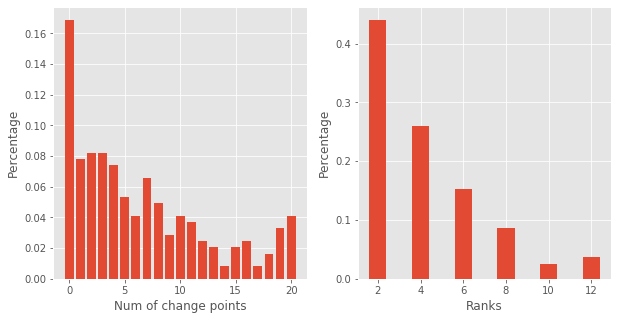

In [45]:
plt.figure(figsize=[10, 5])

plt.subplot(121)
plt.bar(chgs, np.array(chgCts)/len(fils))
plt.xlabel("Num of change points")
plt.ylabel("Percentage")

plt.subplot(122)
plt.bar(ranks, np.array(rCts)/len(fils))
plt.xticks(ranks, ranks)
plt.xlabel("Ranks")
_ = plt.ylabel("Percentage")
#plt.savefig("./ncptsRanks.jpg")

## U, weighted U and correlation

In [46]:
import pandas as pd
import scipy.stats as ss
from sklearn.cluster import KMeans
from sklearn.cluster import Birch
from collections import defaultdict as ddict

In [47]:
fcRDF = pd.read_csv("../necessary files/AALICA.csv")
fcR = np.array(fcRDF)[:90, :]
names = list(fcRDF.columns)
names = [name.strip() for name in names]

In [48]:
def minmax(x):
    num = x - np.min(x)
    den = np.max(x) - np.min(x)
    return num/den

In [49]:
fcR = np.array([minmax(fcR[:, i]) for i in range(7)])
fcR = fcR.T

In [50]:
Us = []
for fil in fils:
    with open(fil, "rb") as f:
        res = pickle.load(f)
    r = res.DetectObj.paras.r
    rUs = res.DetectObj.midRes.eigVecs[:, :r]
    kpidxs = np.where(np.diff(np.concatenate([[np.Inf], np.abs(rUs[0, :])])) != 0)[0]
    for ix in kpidxs:
        Us.append(rUs[:, ix])

In [51]:
absUs = np.array(np.abs(Us))

In [52]:
absUsList =[minmax(absUs[i, :]) for i in range(absUs.shape[0])]
absUs = np.array(absUsList)

In [257]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(absUs)
labs = kmeans.labels_

In [56]:
corrs = ddict(list)
for absU in absUs:
    for j, name in enumerate(names):
        corrs[name].append(ss.pearsonr(fcR[:, j], absU)[0])

Select U with largest correlation with Default network, plot the mean of all U, 97.5 and 2.5 quantile of corresponding U!

In [73]:
midxs = np.argmax(np.array(corDF), axis=1)
for i, name in enumerate(names):
    maxU = absUs[midxs==i, :]
    maxUcorrV = np.array(corrs[name])[midxs==i]
    fname1 = f"max_{name}_U.txt"
    fname2 = f"max_{name}_U_corrV.txt"
    np.savetxt(resDir/fname1, maxU)
    np.savetxt(resDir/fname2, maxUcorrV)

### boxplot for the correlation in each cluster for U

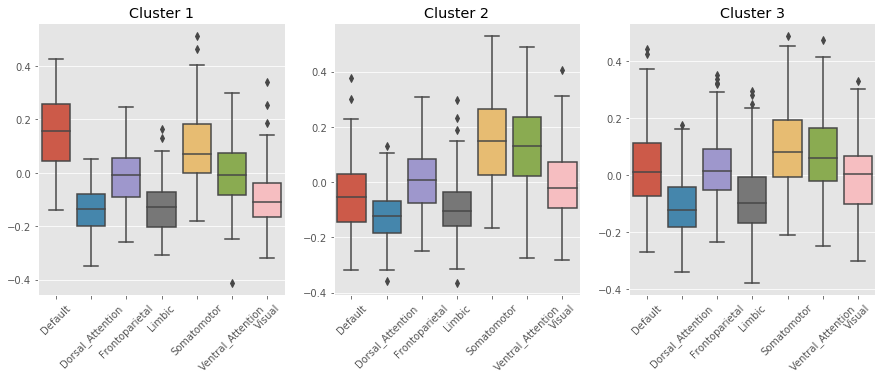

In [261]:
plt.figure(figsize=[15, 5])
for i in range(1, 4):
    plt.subplot(1, 3, i)
    plt.title(f"Cluster {i}")
    sns.boxplot(data=corDF.iloc[labs==(i-1), :])
    plt.xticks(rotation=45)
    
#plt.savefig("corr_U_cluster.jpg")

### Barplot for the percentage of the largest correlations with the 7 canonical networks for U

In [282]:
corArr = np.array(corDF)
maxIdxs = np.argmax(corArr, axis=1)

In [283]:
larCorrCT = Counter(maxIdxs)

In [284]:
pers = [larCorrCT[i]/len(maxIdxs) for i in range(7)]

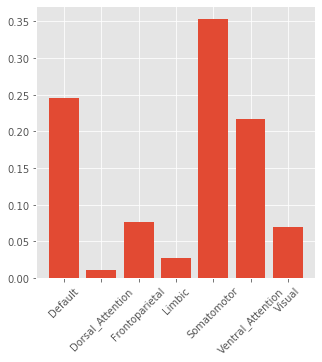

In [286]:
plt.figure(figsize=(5, 5))
plt.bar(names, pers)
_ = plt.xticks(rotation=45)
plt.savefig("./bar_U_maxCorr.jpg")

## Weighted U

In [74]:
wUs = []
for fil in fils:
    with open(fil, "rb") as f:
        res = pickle.load(f)
    optDet = res.DetectObj
    eigVecs = optDet.midRes.eigVecs[:, :optDet.paras.r]
    kpidxs = np.concatenate([[0], optDet.ecpts]).astype(np.int)
    eigVals = optDet.RecResCur.LamMs[:, kpidxs]
    wU = eigVecs.dot(eigVals)
    for ii in range(wU.shape[1]):
        wUs.append(wU[:, ii])

In [75]:
abswUs = np.abs(np.array(wUs))

In [76]:
abswUsList =[minmax(abswUs[i, :]) for i in range(abswUs.shape[0])]
abswUs = np.array(abswUsList)

In [77]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(abswUs)
wlabs = kmeans.labels_

In [78]:
#brc = Birch(n_clusters=3)
#brc.fit(abswUs)
#wlabs = brc.labels_

In [79]:
wCorrs = ddict(list)
for abswU in abswUs:
    for j, name in enumerate(names):
        wCorrs[name].append(ss.pearsonr(fcR[:, j], abswU)[0])

In [80]:
wCorDF = pd.DataFrame(wCorrs)

Select wU with largest correlation with Default network, plot the mean of all wU, 97.5 and 2.5 quantile of corresponding wU!

In [82]:
midxs = np.argmax(np.array(wCorDF), axis=1)
for i, name in enumerate(names):
    maxwU = abswUs[midxs==i, :]
    maxwUcorrV = np.array(wCorrs[name])[midxs==i]
    fname1 = f"max_{name}_wU.txt"
    fname2 = f"max_{name}_wU_corrV.txt"
    np.savetxt(resDir/fname1, maxwU)
    np.savetxt(resDir/fname2, maxwUcorrV)

### boxplot for the correlation in each cluster for weighted U

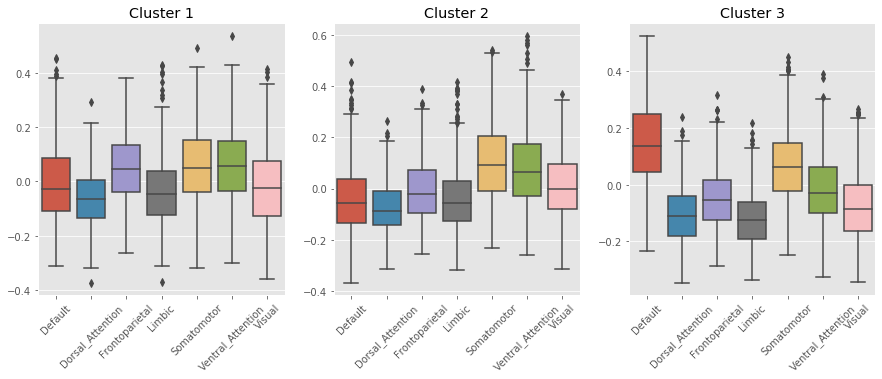

In [279]:
plt.figure(figsize=[15, 5])
for i in range(1, 4):
    plt.subplot(1, 3, i)
    plt.title(f"Cluster {i}")
    sns.boxplot(data=wCorDF.iloc[wlabs==(i-1), :])
    plt.xticks(rotation=45)
#plt.savefig("corr_wU_cluster.jpg")

### Barplot for the percentage of the largest correlations with the 7 canonical networks for weighted U

In [287]:
wCorArr = np.array(wCorDF)
maxIdxs = np.argmax(wCorArr, axis=1)

In [288]:
larwCorrCT = Counter(maxIdxs)

In [289]:
pers = [larwCorrCT[i]/len(maxIdxs) for i in range(7)]

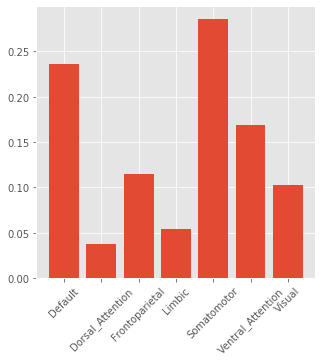

In [290]:
plt.figure(figsize=(5, 5))
plt.bar(names, pers)
_ = plt.xticks(rotation=45)
plt.savefig("./bar_wU_maxCorr.jpg")

In [247]:
#np.savetxt("allCorrwU.txt", wCorArr)
#np.savetxt("allCorr.txt", corArr)

In [292]:
for i, fil in enumerate(fils):
    with open(fil, "rb") as f:
        res = pickle.load(f)
    np.savetxt(f"./tmp/fMRI_{i}.txt", res.DetectObj.nYmat)

### Regression canonical networks on $U$ 

In [221]:
from sklearn.linear_model import LinearRegression as LR

In [243]:
corLinRess = ddict(list)
for fil in fils:
    with open(fil, "rb") as f:
        res = pickle.load(f)
    optDet = res.DetectObj
    #Xs = np.abs(optDet.midRes.eigVecs[:, :10])
    Xs = np.abs(optDet.midRes.eigVecs[:, :optDet.paras.r])
    kpidxs = np.where(np.diff(np.concatenate([[np.Inf], Xs[0, :]])) != 0)[0]
    Xs = np.array([minmax(Xs[:, ii]) for ii in kpidxs]).T
    for ix, name in enumerate(names):
        LinReg = LR()
        Ys = fcR[:, ix]
        LinReg.fit(Xs, Ys)
        preYs = LinReg.predict(Xs)
        corLinRess[name].append(ss.pearsonr(Ys, preYs)[0])

In [244]:
corLinResDF = pd.DataFrame(corLinRess)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

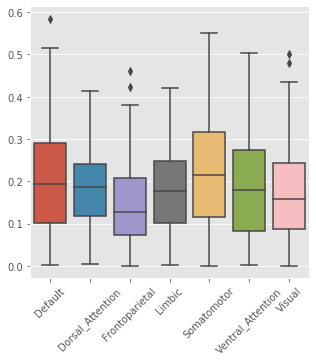

In [281]:
plt.figure(figsize=[5, 5])
sns.boxplot(data=corLinResDF)
plt.xticks(rotation=45)
#plt.savefig("reg_U_corr.jpg")